# Gesture Recognition


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| --- | --- |
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |



### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.



In [1]:
## Checking the GPU configuration
!nvidia-smi

Tue Aug  8 07:33:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Data:

### Importing all necessary Libraries:

In [2]:
# importing libraries
import numpy as np, pandas as pd
import random as rn
import os
from imageio import imread
import tensorflow as tf
from keras import backend as K
import cv2
import matplotlib.pyplot as plt
import datetime
import time

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, GRU,LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import mobilenet

import warnings
warnings.filterwarnings('ignore')

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

## Deriving Data Folder Path:


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!unzip -qq /content/gdrive/MyDrive/ML/Project_data.zip

In [7]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 30

In [8]:
# assigning Train and Validation Path variables

train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


num_frames = 30
classes_gestures = 5


# training sequences = 663
# validation sequences = 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def fetch_batch_data(source_path, folder_list, batch_size, num_gesture_frames, image_size, num_channels, batch, img_idx, t) :
   # num_gesture_frames is the number of images you use for each video, (image_size,image_size) is the final size of the input images and 3 is the number of channels RGB
  batch_data = np.zeros((batch_size, num_gesture_frames, image_size, image_size, num_channels))

  # batch_labels is the one hot representation of the output
  batch_labels = np.zeros((batch_size, classes_gestures))

  # iterate over batch_size
  for folder in range(batch_size):
      gesture_inf_array = t[folder + batch * batch_size].strip().split(';')
      imgs = os.listdir(source_path+'/'+ gesture_inf_array[0]) # read all the images in the folder
      for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
          # for coloured images
          if num_channels == 3 :
            image = imread(source_path + '/' + gesture_inf_array[0] +'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image = cv2.resize(image, (image_size, image_size))

            batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0  #normalise and feed in the image
          # for greyscale images
          else :
            image = cv2.imread(source_path + '/' + gesture_inf_array[0] +'/'+imgs[item], cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (image_size, image_size))
            batch_data[folder,idx,:,:,0] = image / 255.0

      batch_labels[folder, int(gesture_inf_array[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [10]:
def generator(source_path, folder_list, batch_size, num_frames_selected, image_size, num_channels):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =  np.round(np.linspace(0, num_frames - 1, num_frames_selected)).astype(int) #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches =  len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield fetch_batch_data(source_path, folder_list, batch_size, num_frames_selected, image_size, num_channels, batch, img_idx, t)

        # write the code for the remaining data points which are left after full batches

        rem_batch_size = len(t) % batch_size
        yield fetch_batch_data(source_path, folder_list, rem_batch_size, num_frames_selected, image_size, num_channels, num_batches, img_idx, t)



In [11]:
# func to plot the train/validation accuracies and losses
def plot_train_val_accuracy_loss_graph(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    # losses subplot
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    # accuracies subplot
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.show()

### Model Function:

In [12]:
def build_model(model_text, model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate=0.001) :
  # Adam optimizer
  optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  # print (model.summary())

  # train generator
  train_generator = generator(train_path, train_doc, batch_size, num_gesture_frames, image_size, num_channels)
  # val generator
  val_generator = generator(val_path, val_doc, batch_size, num_gesture_frames, image_size, num_channels)

  num_train_sequences = len(train_doc)
  num_val_sequences = len(val_doc)

  #The "steps_per_epoch" and "validation_steps" are used by "fit_generator" to decide the number of next() calls it need to make.

  if (num_train_sequences % batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  model_name = model_text + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
      os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'


  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
  LR = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, verbose = 0, patience = 4)
  callbacks_list = [checkpoint, LR]

  history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

  plot_train_val_accuracy_loss_graph(history)
  return history

### Model Memory function:

In [13]:
# functiong to get memory usage by the model
def get_model_memory_usg(batch_size, model):
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usg(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    mbs = np.round(total_memory / (1024.0 ** 2), 3) + internal_model_mem_count
    return mbs

### Model:
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Using Conv_3D :

In [14]:
def model_cnn3d_only(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons) :
  model = Sequential()
  model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(num_gesture_frames,image_size,image_size,num_channels)))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(32, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(64, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Conv3D(128, (2, 2, 2), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))

  model.add(Flatten())
  model.add(Dense(dense_neurons,activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(dense_neurons // 2,activation='relu'))
  if batch_normalize:
    model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(classes_gestures,activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("Conv3d_only", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate),model

### Model - 1

Total params: 357,541
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.6151 - categorical_accuracy: 0.1719Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to Conv3d_only_2023-08-0807_34_51.945246/model-00001-1.61506-0.17195-1.59764-0.18000.h5
23/23 [==============================] - 64s 2s/step - loss: 1.6151 - categorical_accuracy: 0.1719 - val_loss: 1.5976 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5965 - categorical_accuracy: 0.2308
Epoch 2: saving model to Conv3d_only_2023-08-0807_34_51.945246/model-00002-1.59647-0.23077-1.58056-0.33000.h5
23/23 [==============================] - 46s 2s/step - loss: 1.5965 - categorical_accuracy: 0.2308 - val_loss: 1.5806 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.5289 - categorical_accuracy: 0.2851
Ep

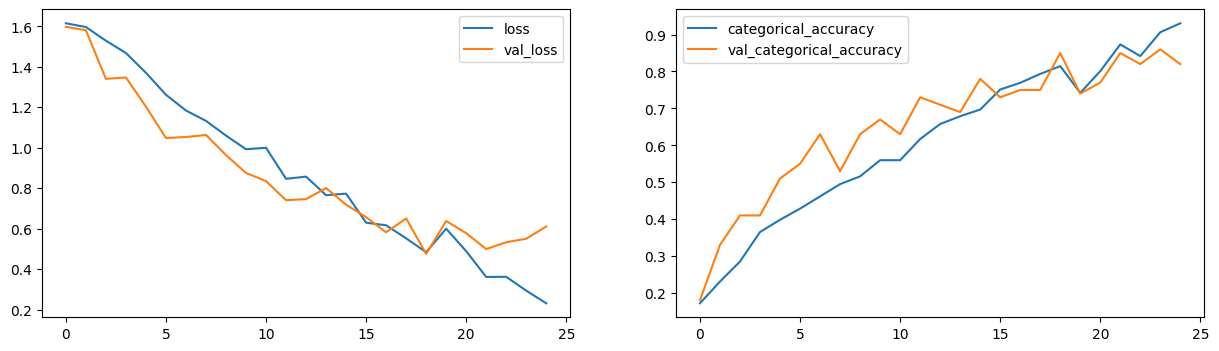

Execution time(in secs):  1142.6416866779327 Memory usage(in MB):  632.346
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
18  0.483591               0.81448  0.474901                      0.85  0.001


In [15]:
# Using batch_size=30, num_epochs=25, num_gesture_frames=30, image_size= 64, num_channels=1, batch_normalize= False, learning_rate= 0.001, dropout= 0.25, dense_neurons= 128
st = time.time()
batch_size=30
hist,model = model_cnn3d_only(batch_size=30, num_epochs=25, num_gesture_frames=30,
                                   image_size= 64, num_channels=1, batch_normalize= False,
                                   learning_rate= 0.001, dropout= 0.25, dense_neurons= 128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 2

Total params: 2,218,501
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.1946Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to Conv3d_only_2023-08-0807_53_54.522747/model-00001-1.60995-0.19457-1.51675-0.25000.h5
23/23 [==============================] - 83s 3s/step - loss: 1.6099 - categorical_accuracy: 0.1946 - val_loss: 1.5167 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4467 - categorical_accuracy: 0.3363
Epoch 2: saving model to Conv3d_only_2023-08-0807_53_54.522747/model-00002-1.44669-0.33635-1.23947-0.42000.h5
23/23 [==============================] - 78s 4s/step - loss: 1.4467 - categorical_accuracy: 0.3363 - val_loss: 1.2395 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.3646 - categorical_accuracy: 0.3982


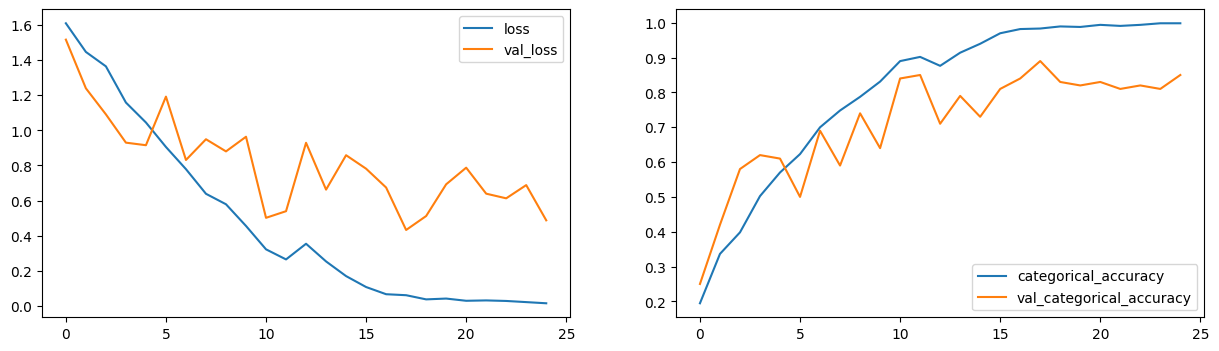

Execution time(in secs):  1911.7701396942139 Memory usage(in MB):  2532.301
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
17  0.060624              0.983409   0.43227                      0.89  0.0002


In [16]:
st = time.time()
hist,model = model_cnn3d_only(batch_size= 30, num_epochs= 25, num_gesture_frames= 30,
                                   image_size= 128, num_channels= 3, batch_normalize= False,
                                   learning_rate= 0.001, dropout= 0.25, dense_neurons= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### Model - 3

Total params: 645,637
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6067 - categorical_accuracy: 0.2142Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to Conv3d_only_2023-08-0808_25_46.246961/model-00001-1.60669-0.21418-1.57621-0.26000.h5
23/23 [==============================] - 37s 1s/step - loss: 1.6067 - categorical_accuracy: 0.2142 - val_loss: 1.5762 - val_categorical_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5587 - categorical_accuracy: 0.2217
Epoch 2: saving model to Conv3d_only_2023-08-0808_25_46.246961/model-00002-1.55871-0.22172-1.44021-0.24000.h5
23/23 [==============================] - 36s 2s/step - loss: 1.5587 - categorical_accuracy: 0.2217 - val_loss: 1.4402 - val_categorical_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.4430 - categorical_accuracy: 0

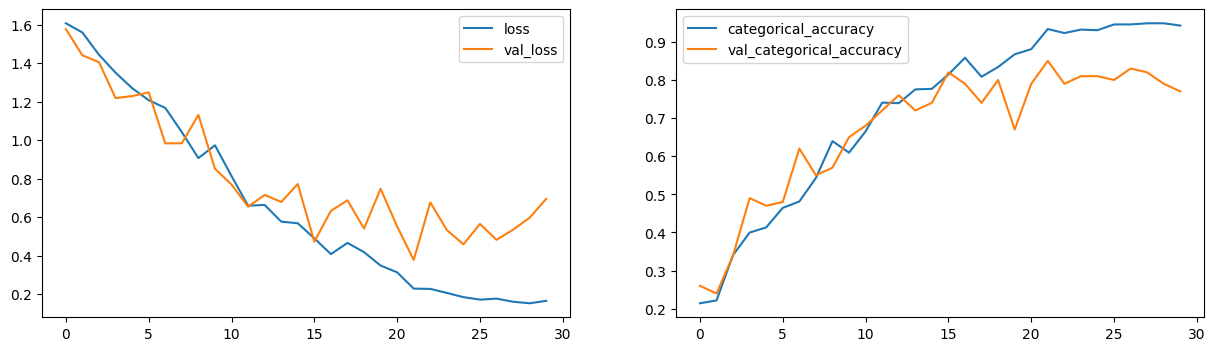

Execution time(in secs):  1044.5189321041107 Memory usage(in MB):  341.458
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
21  0.229136              0.933635  0.378018                      0.85  0.0001


In [17]:
st = time.time()
hist,model = model_cnn3d_only(batch_size= 30, num_epochs= 30, num_gesture_frames= 16,
                                   image_size= 64, num_channels= 3, batch_normalize= False,
                                   learning_rate= 0.0005, dropout=0.25, dense_neurons=256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### Model - 4

Total params: 357,797
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/35
23/23 [==============================] - ETA: 0s - loss: 1.7481 - categorical_accuracy: 0.2308Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to Conv3d_only_2023-08-0808_43_10.804781/model-00001-1.74814-0.23077-1.60440-0.20000.h5
23/23 [==============================] - 47s 2s/step - loss: 1.7481 - categorical_accuracy: 0.2308 - val_loss: 1.6044 - val_categorical_accuracy: 0.2000 - lr: 5.0000e-04
Epoch 2/35
23/23 [==============================] - ETA: 0s - loss: 1.4943 - categorical_accuracy: 0.3183
Epoch 2: saving model to Conv3d_only_2023-08-0808_43_10.804781/model-00002-1.49425-0.31825-1.58389-0.23000.h5
23/23 [==============================] - 44s 2s/step - loss: 1.4943 - categorical_accuracy: 0.3183 - val_loss: 1.5839 - val_categorical_accuracy: 0.2300 - lr: 5.0000e-04
Epoch 3/35
23/23 [==============================] - ETA: 0s - loss: 1.4053 - categorical_accuracy: 0

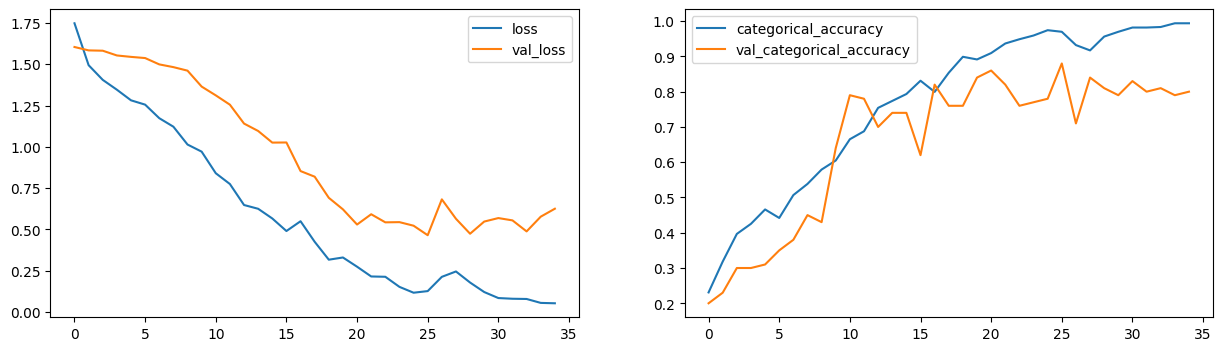

Execution time(in secs):  1585.0539984703064 Memory usage(in MB):  632.354
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
25  0.125673              0.969834  0.464156                      0.88  0.0005


In [18]:
st = time.time()
batch_size= 30
hist,model = model_cnn3d_only(batch_size= 30, num_epochs=35, num_gesture_frames= 30,
                                   image_size= 64, num_channels=1, batch_normalize=True,
                                   learning_rate= 0.0005, dropout= 0.35, dense_neurons=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### CNN_LSTM function:

In [19]:
def model_cnn_lstm(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons, rnn_cells) :
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                            input_shape=(num_gesture_frames, image_size, image_size, num_channels)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(rnn_cells))

  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(classes_gestures, activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn_lstm", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate), model

### Model - 5

Total params: 680,357
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6139 - categorical_accuracy: 0.1976Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to cnn_lstm_2023-08-0809_09_36.176252/model-00001-1.61390-0.19759-1.59340-0.21000.h5
23/23 [==============================] - 74s 3s/step - loss: 1.6139 - categorical_accuracy: 0.1976 - val_loss: 1.5934 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5719 - categorical_accuracy: 0.2715
Epoch 2: saving model to cnn_lstm_2023-08-0809_09_36.176252/model-00002-1.57191-0.27149-1.41264-0.40000.h5
23/23 [==============================] - 69s 3s/step - loss: 1.5719 - categorical_accuracy: 0.2715 - val_loss: 1.4126 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.4294 - categorical_accuracy: 0.3665
Epoch 3:

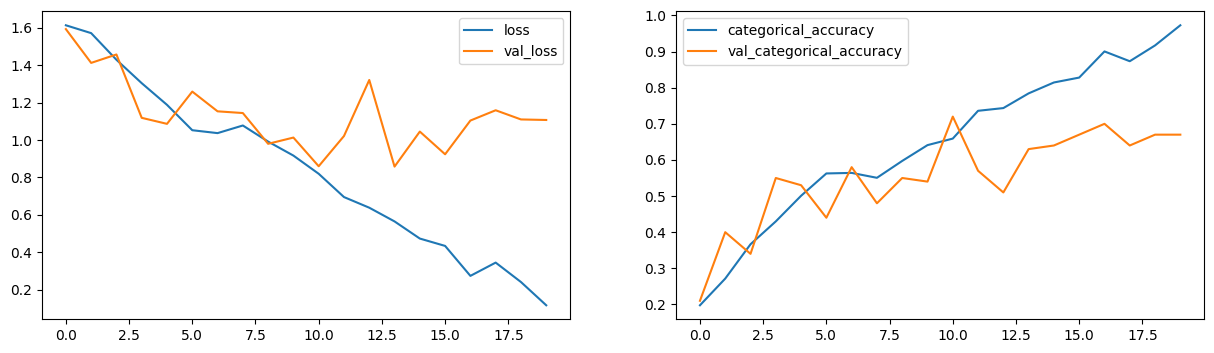

Execution time(in secs):  2855.357833147049 Memory usage(in MB):  551.07
Best model stats: 
        loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
13  0.564599              0.784314   0.85789                      0.63  0.001


In [20]:
hist,model = model_cnn_lstm(batch_size=30, num_epochs=20, num_gesture_frames= 30,
                                      image_size=64, num_channels=3, batch_normalize=False,
                                      learning_rate=.001, dropout=0.25, dense_neurons=128, rnn_cells=64)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best model stats: ")
print(df_best)



### Model - 6

Total params: 2,572,677
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.6222 - categorical_accuracy: 0.2217Source path =  ./Project_data/val ; batch size = 40

Epoch 1: saving model to cnn_lstm_2023-08-0809_30_46.441447/model-00001-1.62216-0.22172-1.60797-0.27000.h5
17/17 [==============================] - 64s 3s/step - loss: 1.6222 - categorical_accuracy: 0.2217 - val_loss: 1.6080 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.5985 - categorical_accuracy: 0.2368
Epoch 2: saving model to cnn_lstm_2023-08-0809_30_46.441447/model-00002-1.59848-0.23680-1.54778-0.21000.h5
17/17 [==============================] - 51s 3s/step - loss: 1.5985 - categorical_accuracy: 0.2368 - val_loss: 1.5478 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.4843 - categorical_accuracy: 0.3469
Epoch 

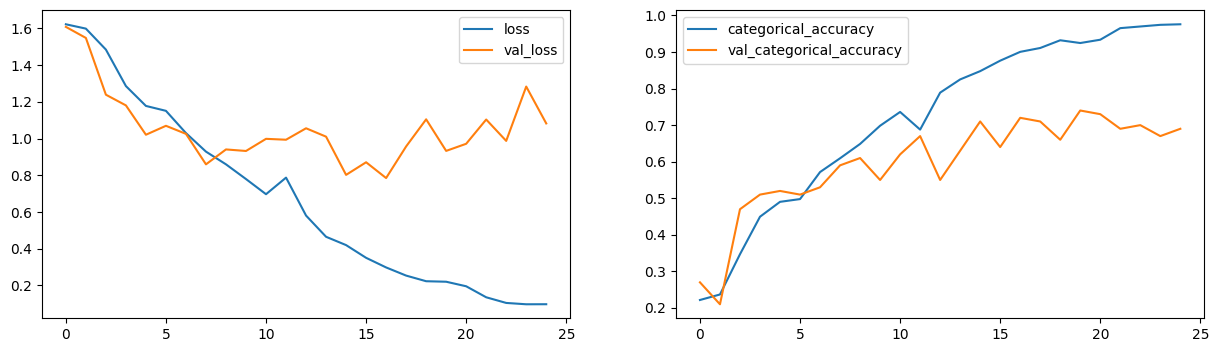

Execution time(in secs):  4120.062770843506 Memory usage(in MB):  2934.873
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
16  0.297949              0.900452  0.784757                      0.72  0.0002


In [21]:
batch_size=40
hist,model = model_cnn_lstm(batch_size=40, num_epochs=25, num_gesture_frames=30,
                                      image_size=128 ,num_channels=1, batch_normalize=False,
                                      learning_rate= 0.001, dropout=0.25, dense_neurons=128, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### Model - 7

Total params: 4,916,869
Source path =  ./Project_data/train ; batch size = 25
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6061 - categorical_accuracy: 0.2051Source path =  ./Project_data/val ; batch size = 25

Epoch 1: saving model to cnn_lstm_2023-08-0809_51_51.182990/model-00001-1.60615-0.20513-1.54143-0.37000.h5
27/27 [==============================] - 68s 2s/step - loss: 1.6061 - categorical_accuracy: 0.2051 - val_loss: 1.5414 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.4363 - categorical_accuracy: 0.3454
Epoch 2: saving model to cnn_lstm_2023-08-0809_51_51.182990/model-00002-1.43627-0.34540-1.42521-0.43000.h5
27/27 [==============================] - 51s 2s/step - loss: 1.4363 - categorical_accuracy: 0.3454 - val_loss: 1.4252 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.3539 - categorical_accuracy: 0.3952
Epoch 

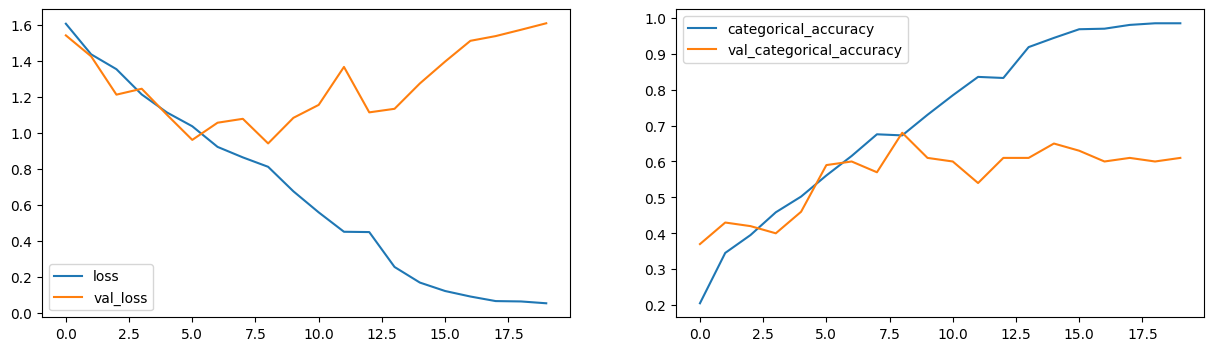

Execution time(in secs):  5168.104520320892 Memory usage(in MB):  2177.918
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
8  0.812299                0.6727  0.942057                      0.68  0.001


In [22]:
batch_size=25
hist,model = model_cnn_lstm(batch_size=25, num_epochs=20, num_gesture_frames=30,
                                      image_size=140, num_channels=1, batch_normalize=False,
                                      learning_rate=0.001, dropout= 0.25, dense_neurons= 256, rnn_cells= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### Model - 8

Total params: 1,838,501
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6303 - categorical_accuracy: 0.2081Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to cnn_lstm_2023-08-0810_09_19.751128/model-00001-1.63026-0.20814-1.59414-0.24000.h5
23/23 [==============================] - 71s 3s/step - loss: 1.6303 - categorical_accuracy: 0.2081 - val_loss: 1.5941 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.6005 - categorical_accuracy: 0.2217
Epoch 2: saving model to cnn_lstm_2023-08-0810_09_19.751128/model-00002-1.60047-0.22172-1.60136-0.37000.h5
23/23 [==============================] - 62s 3s/step - loss: 1.6005 - categorical_accuracy: 0.2217 - val_loss: 1.6014 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.5205 - categorical_accuracy: 0.2775
Epoch 

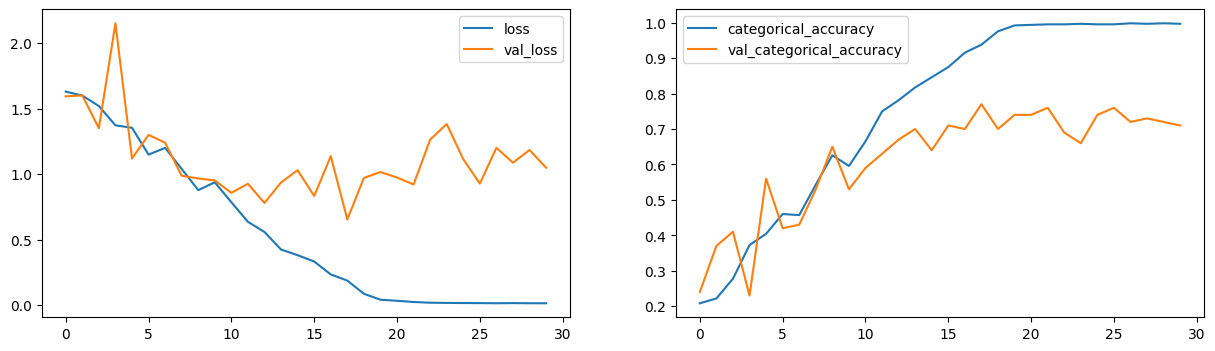

Execution time(in secs):  7090.404725313187 Memory usage(in MB):  555.598
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
17  0.188059               0.93816  0.654903                      0.77  0.0002


In [23]:
batch_size= 30
hist,model = model_cnn_lstm(batch_size= 30, num_epochs= 30, num_gesture_frames= 30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 512, rnn_cells= 256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)



### CNN_GRU function:

In [24]:
def model_cnn_GRU(batch_size, num_epochs, num_gesture_frames, image_size, num_channels, batch_normalize, learning_rate, dropout, dense_neurons, rnn_cells) :
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                            input_shape=(num_gesture_frames, image_size, image_size, num_channels)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(GRU(rnn_cells))

  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dropout(dropout))

  model.add(Dense(classes_gestures, activation='softmax'))

  print('Total params: {:,}'.format(model.count_params()))

  return build_model("cnn_gru", model, batch_size, num_epochs, num_gesture_frames, image_size, num_channels, learning_rate), model

### Model - 9

Total params: 852,901
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.6118 - categorical_accuracy: 0.1916Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to cnn_gru_2023-08-0810_41_21.645507/model-00001-1.61181-0.19155-1.60392-0.16000.h5
23/23 [==============================] - 67s 3s/step - loss: 1.6118 - categorical_accuracy: 0.1916 - val_loss: 1.6039 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5808 - categorical_accuracy: 0.2715
Epoch 2: saving model to cnn_gru_2023-08-0810_41_21.645507/model-00002-1.58083-0.27149-1.47928-0.32000.h5
23/23 [==============================] - 61s 3s/step - loss: 1.5808 - categorical_accuracy: 0.2715 - val_loss: 1.4793 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.4399 - categorical_accuracy: 0.3560
Epoch 3: s

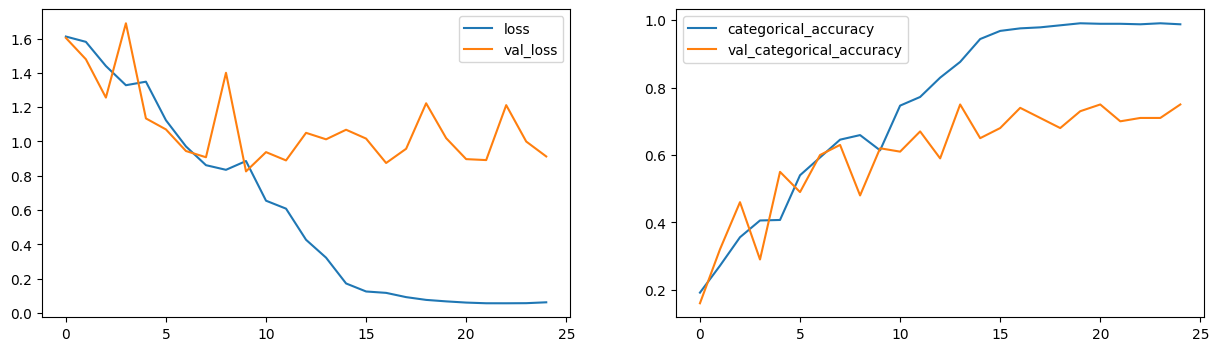

Execution time(in secs):  8682.670178890228 Memory usage(in MB):  551.736
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
9  0.885763              0.613876  0.825401                      0.62  0.001


In [25]:
hist,model = model_cnn_GRU(batch_size=30, num_epochs=25, num_gesture_frames=30,
                                      image_size= 64, num_channels= 3, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 128, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 10

Total params: 2,049,413
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.6144 - categorical_accuracy: 0.1961Source path =  ./Project_data/val ; batch size = 40

Epoch 1: saving model to cnn_gru_2023-08-0811_07_53.991309/model-00001-1.61442-0.19608-1.60377-0.24000.h5
17/17 [==============================] - 56s 3s/step - loss: 1.6144 - categorical_accuracy: 0.1961 - val_loss: 1.6038 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 1.5830 - categorical_accuracy: 0.2323
Epoch 2: saving model to cnn_gru_2023-08-0811_07_53.991309/model-00002-1.58305-0.23228-1.47962-0.30000.h5
17/17 [==============================] - 50s 3s/step - loss: 1.5830 - categorical_accuracy: 0.2323 - val_loss: 1.4796 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 1.4550 - categorical_accuracy: 0.3544
Epoch 3:

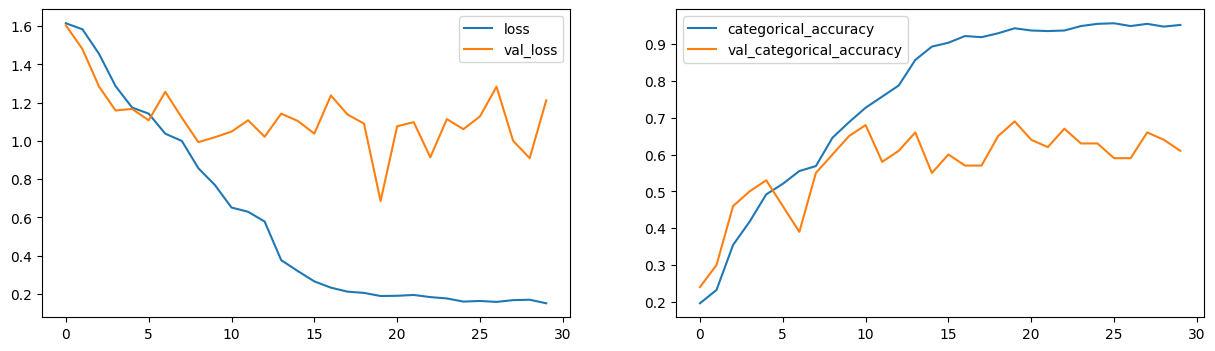

Execution time(in secs):  10213.04247546196 Memory usage(in MB):  2932.916
Best stats:
       loss  categorical_accuracy  val_loss  val_categorical_accuracy       lr
19  0.18902              0.942685  0.685112                      0.69  0.00004


In [26]:
batch_size= 40
hist,model = model_cnn_GRU(batch_size= 40, num_epochs=30, num_gesture_frames=30,
                                      image_size= 128, num_channels= 1, batch_normalize=False,
                                      learning_rate= 0.001, dropout= 0.25, dense_neurons= 256, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 11

Total params: 1,444,261
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6287 - categorical_accuracy: 0.2157Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to cnn_gru_2023-08-0811_33_24.105575/model-00001-1.62874-0.21569-1.59150-0.18000.h5
23/23 [==============================] - 68s 3s/step - loss: 1.6287 - categorical_accuracy: 0.2157 - val_loss: 1.5915 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5884 - categorical_accuracy: 0.1991
Epoch 2: saving model to cnn_gru_2023-08-0811_33_24.105575/model-00002-1.58837-0.19910-1.51197-0.25000.h5
23/23 [==============================] - 69s 3s/step - loss: 1.5884 - categorical_accuracy: 0.1991 - val_loss: 1.5120 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.4940 - categorical_accuracy: 0.3243
Epoch 3:

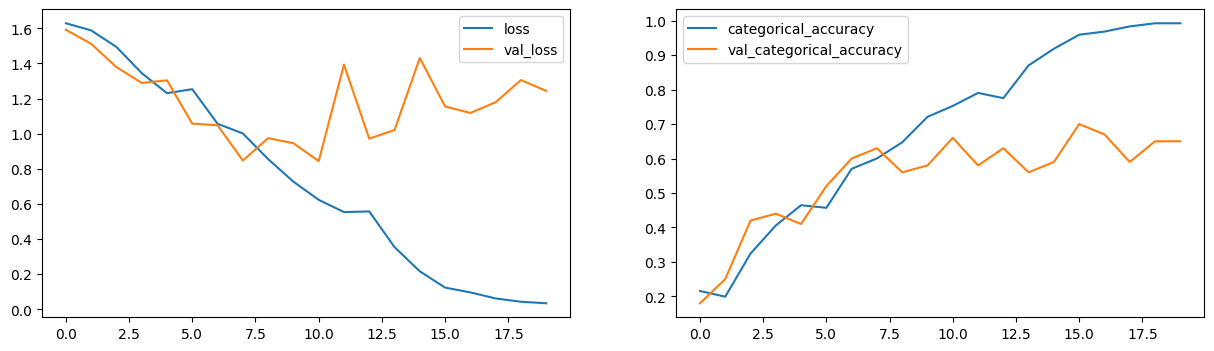

Execution time(in secs):  11519.454283475876 Memory usage(in MB):  554.035
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy     lr
10  0.623423               0.75264  0.844037                      0.66  0.001


In [27]:
batch_size= 30
hist,model = model_cnn_GRU(batch_size= 30, num_epochs= 20, num_gesture_frames=30,
                                      image_size= 64, num_channels=3, batch_normalize=False,
                                      learning_rate= 0.001, dropout = 0.25, dense_neurons= 256, rnn_cells=256)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### Model - 12

---



---



Total params: 1,395,589
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.6087 - categorical_accuracy: 0.1825Source path =  ./Project_data/val ; batch size = 40

Epoch 1: saving model to cnn_gru_2023-08-0811_55_10.536249/model-00001-1.60866-0.18250-1.57734-0.24000.h5
17/17 [==============================] - 60s 3s/step - loss: 1.6087 - categorical_accuracy: 0.1825 - val_loss: 1.5773 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.5327 - categorical_accuracy: 0.3273
Epoch 2: saving model to cnn_gru_2023-08-0811_55_10.536249/model-00002-1.53269-0.32730-1.43088-0.33000.h5
17/17 [==============================] - 48s 3s/step - loss: 1.5327 - categorical_accuracy: 0.3273 - val_loss: 1.4309 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.3339 - categorical_accuracy: 0.4072
Epoch 3:

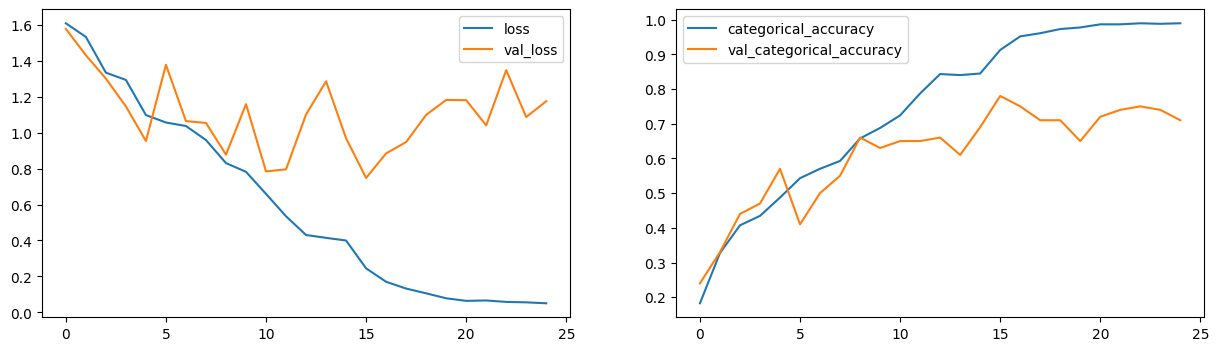

Execution time(in secs):  12724.644776821136 Memory usage(in MB):  1772.834
Best stats:
        loss  categorical_accuracy  val_loss  val_categorical_accuracy      lr
15  0.244764              0.912519  0.747917                      0.78  0.0002


In [28]:
batch_size=40
hist,model = model_cnn_GRU(batch_size=40, num_epochs=25, num_gesture_frames= 30,
                                      image_size=100, num_channels=1, batch_normalize=False,
                                      learning_rate=0.001, dropout= 0.25, dense_neurons=512, rnn_cells=128)
df_train = pd.DataFrame(hist.history)
df_best = df_train[df_train['val_loss'] == df_train['val_loss'].min()]
et = time.time()
elapsed_time = et - st
mbs = get_model_memory_usg(batch_size, model)
print("Execution time(in secs): ", elapsed_time, "Memory usage(in MB): ", mbs)
print("Best stats:")
print(df_best)


### FINAL MODEL:

We selected Conv3D model#1 as the best performing model over CNN+LSTM and CNN+GRU for following reasons:
- Training Accuracy :	81%
- Validation Accuracy:	85%
- Number of parameters are low 357,541 which makes the model computationally less expensive
- Model is Statistically simpler.

